In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import torch
import random
import numpy as np

# Set seed
torch.manual_seed(7)
torch.cuda.manual_seed(7)
torch.cuda.manual_seed_all(7)
np.random.seed(7)
random.seed(7)

# **Load the dataset: en (English)**

In [ ]:
from google.colab import drive
# mount your google drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load train and test datasets
train_df = pd.read_csv("train.tsv",  sep='\t', on_bad_lines='skip')
test_df = pd.read_csv("test.tsv",  sep='\t', on_bad_lines='skip')
print('Train dataset size:', train_df.shape)
print('Test dataset size:', test_df.shape)

Train dataset size: (33845, 6)
Test dataset size: (21832, 6)


In [ ]:
# Since we will only focus on a binary classification, we do not need the id, prompt and model variables
# We will mantain the domain variable to later study how well the model works depending on the domain
train_df = train_df.drop(['id', 'prompt', 'model'], axis=1)
test_df = test_df.drop(['id', 'prompt', 'model'], axis=1)

## Split the data
We will first split the train and test dataset into X_train, y_train, domains_train and X_test, y_test, domains_test, respectivately.

In [ ]:
# Texts
X_train = train_df['text']
X_test = test_df['text']

# Extract labels
y_train = train_df['label']
y_test = test_df['label']

# Extract domain column, we will use it later
domains_train = train_df['domain']
domains_test = test_df['domain']

# Preprocessing
We will create a function that cleans the texts in our dataset.

In [ ]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
stopwords_en = stopwords.words("english")

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import re

def clean_text(text):
    # transform to lower case
    text=str(text).lower()
    # tokenize
    tokens=word_tokenize(text)
    # eliminate stopwords
    tokens = [word for word in tokens if word not in stopwords_en]
    # apply stemming
    tokens = [PorterStemmer().stem(word) for word in tokens]
    # eliminate words with length lower than 3
    min_length = 3
    # ignore words that contain a digit or a special symbol
    p = re.compile('^[a-zA-Z]+$');

    # stored clean tokens
    filtered_tokens=[]
    for token in tokens:
        if len(token)>=min_length and p.match(token):
            filtered_tokens.append(token)

    return filtered_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Label Encoding
Transform the labels to digit format, i.e., 0 : *human*; 1 : *generated*.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

y_train = y_train.tolist()
y_test = y_test.tolist()

le = LabelEncoder()

print("Before transforming: ", y_train[:10])
y_train = le.fit_transform(y_train)
labels = le.classes_
print("After transforming:", y_train[:10])

print("Before transforming: ", y_test[:10])
y_test = le.transform(y_test)
print("After transforming:", y_test[:10])

label2idx={}
for index, label in enumerate(labels):
    label2idx.update([(label, index)])
print('Labels:', label2idx)

Before transforming:  ['generated', 'generated', 'generated', 'human', 'human', 'generated', 'generated', 'human', 'generated', 'generated']
After transforming: [0 0 0 1 1 0 0 1 0 0]
Before transforming:  ['human', 'human', 'generated', 'human', 'human', 'generated', 'human', 'generated', 'generated', 'human']
After transforming: [1 1 0 1 1 0 1 0 0 1]
Labels: {'generated': 0, 'human': 1}


# Naive Bayes Pipeline
Create a pipeline that executes the following:

1. Use of Bag of Words (BoW) to represent our texts.
2. Apply TF-IDF to transform our texts: reflect the importance of a word in a text relative to a collection of texts (dataset).
3. Implement Classification algorithm.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

pipeline_NB = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),    # represent texts using Bag of Words
    ('tf', TfidfTransformer()),                       # tranform texts using TF-IDF
    ('nb', MultinomialNB()),                          # implement SVC algorithm
])

## Cross-Validation
Apply RandomizedSearchCV with different combinations of parameters, and evaluate over validation dataset to find the best parameters.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# alpha: high-underfitting, low-overfitting
param_grid_NB = {
    'nb__alpha': np.arange(0, 1, 0.05)
}
rand_NB = RandomizedSearchCV(estimator=pipeline_NB, param_distributions=param_grid_NB, n_iter=5, scoring='f1_macro', cv=5, verbose=False)
rand_NB.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('bow',
                                              CountVectorizer(analyzer=<function clean_text at 0x7a54aa62f640>)),
                                             ('tf', TfidfTransformer()),
                                             ('nb', MultinomialNB())]),
                   n_iter=5,
                   param_distributions={'nb__alpha': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
                   scoring='f1_macro', verbose=False)

In [ ]:
rand_NB.best_score_

0.6760926134348921

In [ ]:
rand_NB.best_params_

{'nb__alpha': 0.8500000000000001}

In [ ]:
rand_NB.cv_results_

{'mean_fit_time': array([44.84699521, 45.58136458, 47.22208996, 44.48124356, 44.84024363]),
 'std_fit_time': array([0.64771169, 0.8899198 , 4.00464396, 0.3770006 , 0.78083328]),
 'mean_score_time': array([11.55161166, 11.01189642, 12.77231889, 11.35545607, 11.17280869]),
 'std_score_time': array([0.05815009, 0.50209336, 3.00236665, 0.39561519, 0.54495921]),
 'param_nb__alpha': masked_array(data=[0.05, 0.8500000000000001, 0.1, 0.25, 0.55],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'nb__alpha': 0.05},
  {'nb__alpha': 0.8500000000000001},
  {'nb__alpha': 0.1},
  {'nb__alpha': 0.25},
  {'nb__alpha': 0.55}],
 'split0_test_score': array([0.66137409, 0.67618001, 0.6632591 , 0.6689706 , 0.67526877]),
 'split1_test_score': array([0.65600758, 0.67336982, 0.6580611 , 0.66201546, 0.6669158 ]),
 'split2_test_score': array([0.66861128, 0.68125908, 0.67030199, 0.67686611, 0.67970487]),
 'split3_test_score': array([0.663535

# Best NB model
Now that we know which parameters are the best for our model, we modify our pipeline to these values.

In [ ]:
pipeline_NB = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),    # represent texts using Bag of Words
    ('tf', TfidfTransformer()),                       # tranform texts using TF-IDF
    ('nb', MultinomialNB(alpha=0.85)),                 # implement Naive Bayes algorithm
])

import time
# Train the pipeline
start_time = time.time()
pipeline_NB.fit(X_train, y_train)
end_time = time.time()
print('Execution time: ', time.strftime("%Hh %Mm %Ss", time.gmtime(end_time-start_time)))

Execution time:  00h 01m 15s


In [ ]:
import joblib
# save best NB model
joblib.dump(pipeline_NB, 'NB_model.pkl')

['NB_model.pkl']

## Evaluation
Once the pipeline has been trained, we will predict the labels for our testing dataset and evaluate our model.

In [ ]:
# Load previously executed NB model
NB_model = joblib.load("NB_model.pkl")

In [ ]:
X_test= X_test.tolist()

# Predict labels of texts in the testing dataset with our model
predictions_NB = NB_model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions_NB, target_names=labels))

              precision    recall  f1-score   support

   generated       0.53      0.94      0.68     11190
       human       0.69      0.14      0.23     10642

    accuracy                           0.55     21832
   macro avg       0.61      0.54      0.45     21832
weighted avg       0.61      0.55      0.46     21832



The F1-score for the generated texts is 0.68, while for the human texts is 0.23.

Overall the  macro F1s-score is 0.45.

[[10538   652]
 [ 9188  1454]]


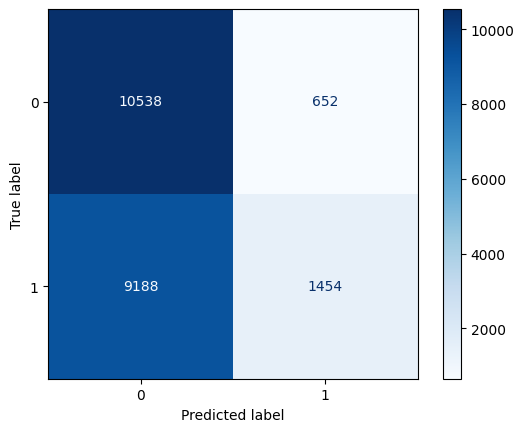

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_test, predictions_NB))
disp_NB=ConfusionMatrixDisplay.from_predictions(y_test, predictions_NB, cmap=plt.cm.Blues)

We observe that the model classifies most of the generated texts correctly (10538 out of 11190). However, out of the total (10642) human texts, it only classifies correctly 1454. While the remaining 9188 human texts are classified as generated, meaning our model is not the best.

### Evaluation for each Domain in Test dataset

We will evaluate the performance of the Naive Bayes model for each of the domains *news* and *reviews*.

Classification Report for News:
              precision    recall  f1-score   support

   generated       0.51      0.93      0.66      5464
       human       0.58      0.09      0.16      5464

    accuracy                           0.51     10928
   macro avg       0.54      0.51      0.41     10928
weighted avg       0.54      0.51      0.41     10928

Classification Report for Reviews:
              precision    recall  f1-score   support

   generated       0.56      0.95      0.71      5726
       human       0.77      0.18      0.29      5178

    accuracy                           0.59     10904
   macro avg       0.67      0.57      0.50     10904
weighted avg       0.66      0.59      0.51     10904



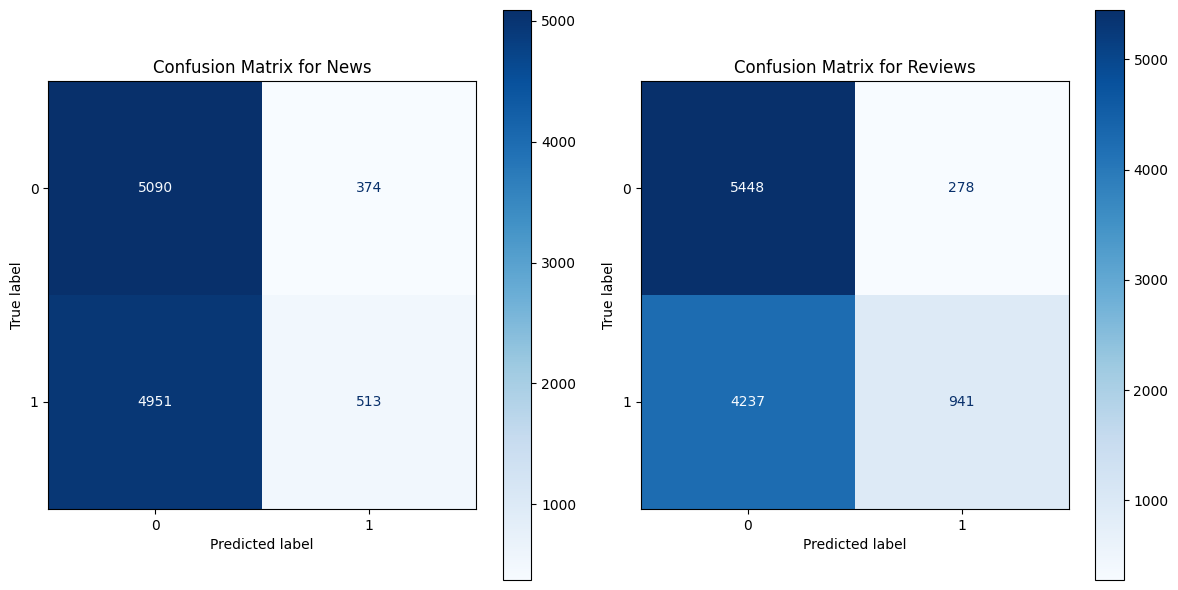

In [ ]:
# Calculate predictions and metrics for news domain
X_test_news = [X_test[i] for i in range(len(X_test)) if domains_test[i] == 'news']
y_test_news = y_test[domains_test=='news']
predictions_NB_news = NB_model.predict(X_test_news)
print("Classification Report for News:")
print(classification_report(y_test_news, predictions_NB_news, target_names=labels))

# Calculate predictions and metrics for reviews domain
X_test_reviews = [X_test[i] for i in range(len(X_test)) if domains_test[i] == 'reviews']
y_test_reviews = y_test[domains_test=='reviews']
predictions_NB_reviews = NB_model.predict(X_test_reviews)
print("Classification Report for Reviews:")
print(classification_report(y_test_reviews, predictions_NB_reviews, target_names=labels))

# Combine the confusion matrices plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

disp_NB_news = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_news, predictions_NB_news))
disp_NB_news.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Confusion Matrix for News')

disp_NB_reviews = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_reviews, predictions_NB_reviews))
disp_NB_reviews.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title('Confusion Matrix for Reviews')

plt.tight_layout()
plt.show()


We observe that the model categorizes very badly the texts written by a human in the news domain.

Moreover, the macro F1s-score is 0.41.

For the texts written by a human in the reviews texts, we see that it does better but still gives many false negatives.

Moreover, the  macro F1s-score is 0.50.